# 0. Importing Libraries

https://www.kaggle.com/code/brendanartley/nih-chest-x-rays-eda
https://www.kaggle.com/code/rahulogoel/chest-x-rays-eda-clahe-enchanced-balanced#Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import cv2
import os
import glob
from itertools import chain

from skimage import io
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

#probably best to not ignore warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_theme()
from sklearn.preprocessing import MultiLabelBinarizer


# 1. Exploring dataset

## 1.1 Loading Data Files

In [2]:
df = pd.read_csv('/home/ozien/Untitled Folder/XAI/Data/Data_Entry_2017.csv')
df = df[df['Patient Age'] <= 120] # remove if age > 120
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


## 1.2 Descriptive statistics

**Interesting Notes**

* The dataset resizes all images to 1024 x 1024 but the original image dimensions are stored in the data frame. These dimensions are not consistent across all images.

* Is there a patient who is 414 years old, or is the Patient Age column using a different scale than years?

* The highest follow-up number is 183. Does this mean one patient has 183 images in the dataset?

In [3]:
print("Rows: ", len(df))
print("Unique Image files: ", df["Image Index"].nunique())
print("Unique Patients: ", df["Patient ID"].nunique())

#descriptive stats
df.describe()

Rows:  112104
Unique Image files:  112104
Unique Patients:  30802


,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


## 1.3 Check Null Values

In [4]:
df.info()

# drop Unnamed
df.drop("Unnamed: 11", axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112104 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112104 non-null  object 
 1   Finding Labels               112104 non-null  object 
 2   Follow-up #                  112104 non-null  int64  
 3   Patient ID                   112104 non-null  int64  
 4   Patient Age                  112104 non-null  int64  
 5   Patient Gender               112104 non-null  object 
 6   View Position                112104 non-null  object 
 7   OriginalImage[Width          112104 non-null  int64  
 8   Height]                      112104 non-null  int64  
 9   OriginalImagePixelSpacing[x  112104 non-null  float64
 10  y]                           112104 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 11.1+ MB


# 2. Exploring Dataset Columns

## 2.1 Image Index

The image names are in the following format `00000001_000.png`. The number before the underscore corresponds to the `Patient ID`, and the number after the underscore is the image number (dependant on `Patient ID`).

**Interesting Notes**

* All the images are stored as PNG images. Since PNG images are higher quality than that JPEG images they take up more storage. This must be kept in mind when developing a model pipeline.

In [5]:
print(df["Image Index"][0:5])

0    00000001_000.png
1    00000001_001.png
2    00000001_002.png
3    00000002_000.png
4    00000003_000.png
Name: Image Index, dtype: object


## 2.2 Finding Labels

The finding labels will be used as the true `labels` when training a model. These are essentially the diagnoses given by a doctor. 

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
- Nodule Mass
- Hernia

**Interesting Notes**

- If the labels are split and ordered alpha-numerically the number of unique pairs changes. ie `Pneumonia|Effusion` should be marked the same as `Effusion|Pneumonia`. This decreases the number of unique labels by ~30.

- ~1600 images have 4+ labels, is this an error? How should these data points be handled? 

In [6]:
print("Unique Combinations Before Transform: ", df["Finding Labels"].nunique())

df["Finding Labels"] = df["Finding Labels"].str.split("|").apply(lambda x: sorted(x)).str.join("|")

print("Actual Unique Combinations: ", df["Finding Labels"].nunique())

Unique Combinations Before Transform:  836
Actual Unique Combinations:  801


In the following plot, the images that have multiple labels are split into their own rows and the raw label count is shown. The majority of the images have `No Finding`, followed by `Effusion`, `Infiltration`, and `Atelectasis`.

The least common label type is a `Hernia`.

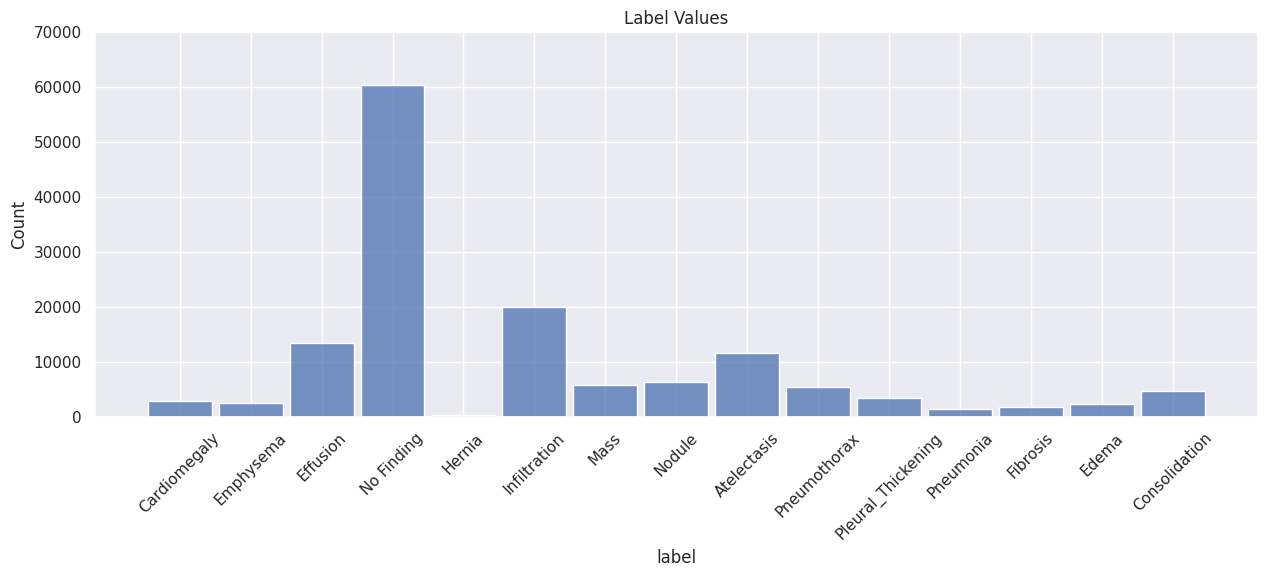

In [7]:
def finding_Labels_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')["var1"]
    test = test.reset_index(drop=True).to_frame()
    test.columns = ["label"]

    fig, ax = plt.subplots(figsize=(15,5))
    ax.tick_params(axis='x', rotation=45)
    sns.histplot(test, x="label", discrete=True, ax=ax, shrink=.9).set_title("Label Values")
    ax.bar_label(ax.containers[0])
    plt.ylim(0,70000)
    plt.show(sns)

finding_Labels_p1(df)

The next hist plot shows the number of labels associated with each image. The vast majority of the x-ray images contain 4 or fewer labels yet some images contain more.

The longest label attached to an image is:

`Atelectasis|Consolidation|Effusion|Fibrosis|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumothorax`

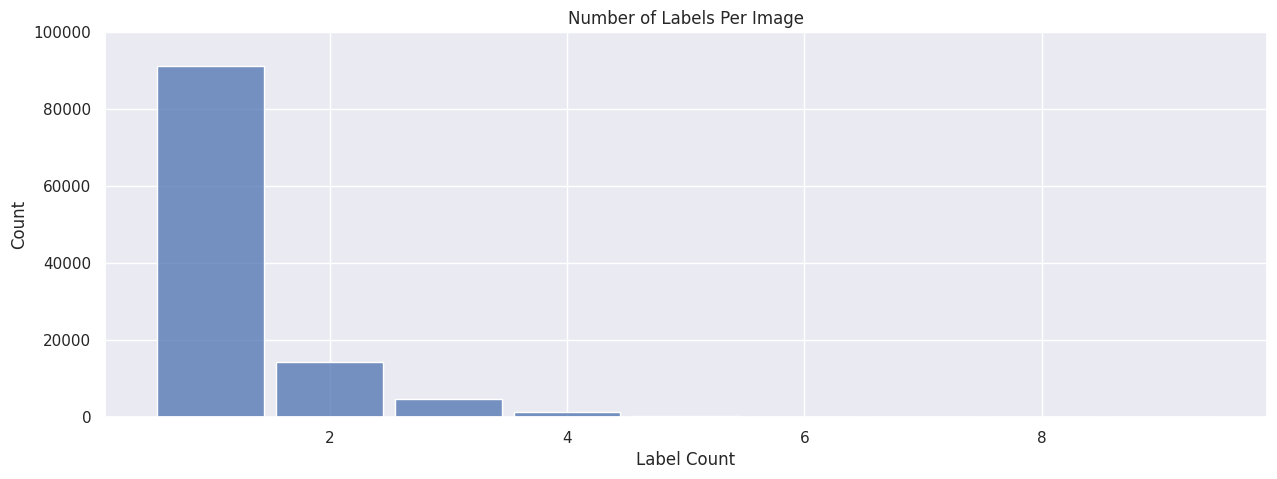

In [8]:
def finding_Labels_p2(df):
    
    test = df["Finding Labels"].str.count(r'\|') + 1
    test = test.reset_index(drop=True).to_frame()
    test.columns = ["Label Count"]

    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(test, x="Label Count", discrete=True, ax=ax, shrink=.9).set_title("Number of Labels Per Image")
    ax.bar_label(ax.containers[0])
    plt.ylim(0,100000)
    plt.show(sns)
    
finding_Labels_p2(df)

## 2.3 Follow-up Number

The follow-up number is an indicator as to how many times a patient is seen.

As expected the plot is heavily right-skewed and most patients have fewer than 10 images in the dataset. That being said there are some extraneous outliers such as the patient with 183 images in the dataset as mentioned earlier.

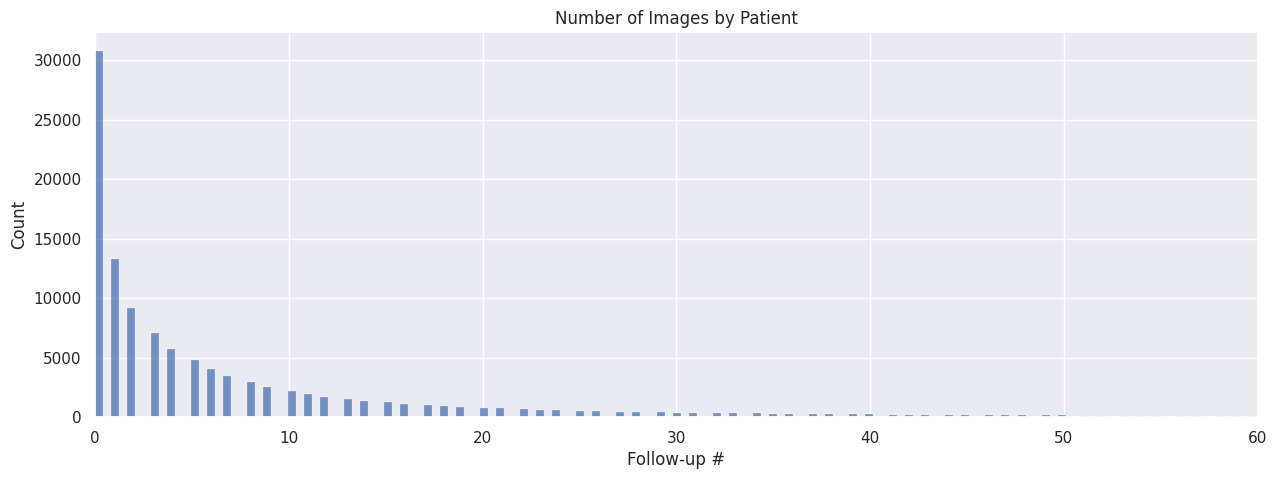

In [9]:
def follow_up_number_p1(df):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(data=df, x="Follow-up #", ax=ax).set_title('Number of Images by Patient')
    plt.xlim(0,60)
    plt.show(sns)

follow_up_number_p1(df)

## 2.4 Patient ID


## 2.5 Patient Age

There are a few errors/mislabelled points in the patient age column, with one patient being 414 years old. Any records with a patient age above 120 are removed from the dataset in the plot.

- In the following plot the majority of patients are between 30-70 years old. That being said there is a nice variety of patient ages in the dataset.

- There are also three groups with a large number of samples relative to their neighbors. Was this a result of the data collection strategy, or are there routine checks done at these ages?

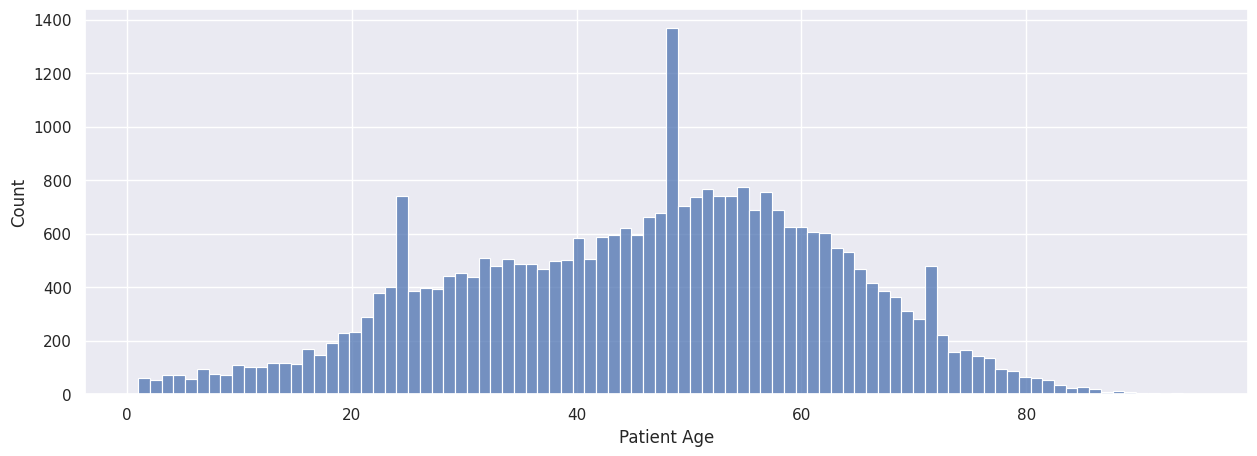

In [10]:
def patient_age_p1(df):
    test = df[df['Patient Age'] <= 120]
    test = df.groupby("Patient ID").agg('first')

    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(test, x="Patient Age", ax=ax, bins=90)
    plt.show(sns)

patient_age_p1(df)

## 2.6 Patient Gender


There are slightly more images of Male patients than Female patients in the dataset, yet this is quite a small difference.

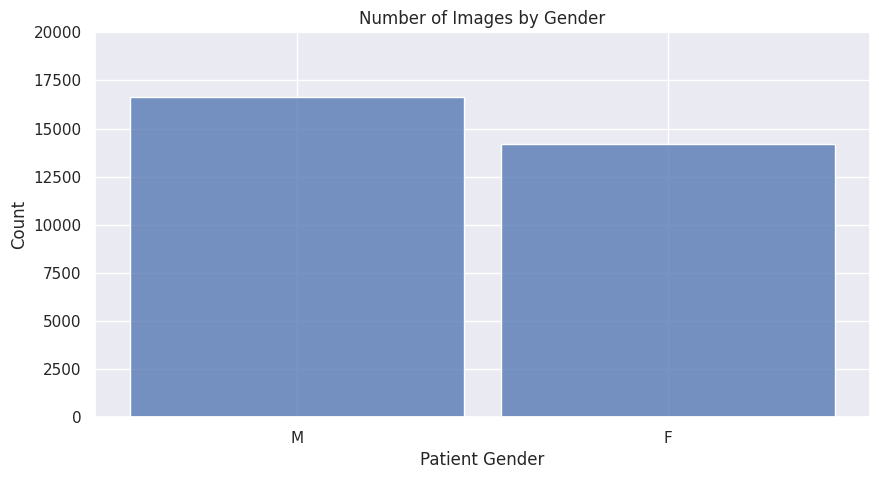

In [11]:
def patient_gender_p1(df):
    #remove duplicate patients
    test = df.groupby("Patient ID").agg('first')

    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(test, x="Patient Gender", discrete=True, ax=ax, shrink=.9).set_title("Number of Images by Gender")
    ax.bar_label(ax.containers[0])
    plt.ylim(0,20000)
    plt.show(sns)
    
patient_gender_p1(df)

## 2.7 View Position

This variable provides us with the "View" at which the image was taken. The two possible values in this column are `PA` or `AP`.

`PA` - From the back (Posterior to Anterior)

`AP` - From the front (Anterior to Posterior)

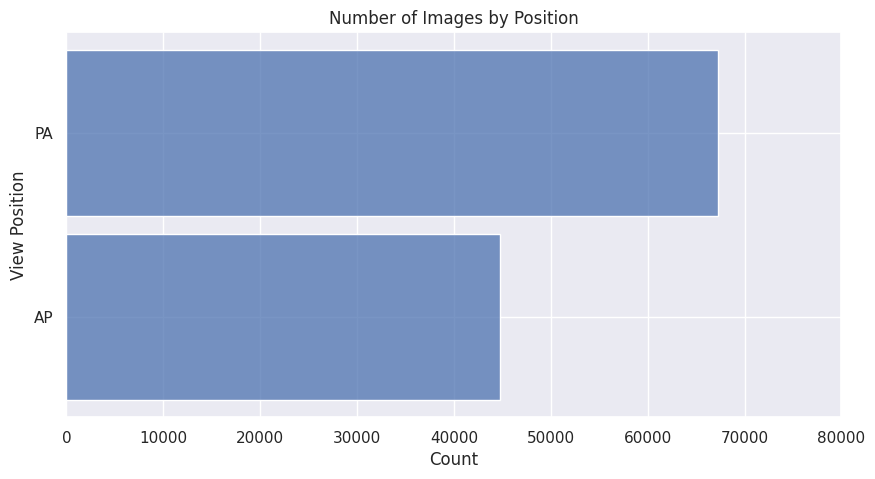

In [12]:
def view_position_p1(df):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(df, y='View Position', discrete=True, ax=ax, shrink=.9).set_title("Number of Images by Position")
    ax.bar_label(ax.containers[0])
    plt.xlim(0, 80000)
    plt.show(sns)
    
view_position_p1(df)

## 2.8 OriginalImageWidth, OriginalImageHeight, OriginalImagePixelSpacing

The remaining columns OriginalImageWidth, OriginalImageHeight, and OriginalImagePixelSpacing provide information on the orginal image dimensions.

For now, these columns will be removed.

In [13]:
cols_of_interest = ["Image Index", "Finding Labels", "Follow-up #",
                   "Patient ID", "Patient Age", "Patient Gender",
                   "View Position"]

df = df[cols_of_interest]
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA
3,00000002_000.png,No Finding,0,2,81,M,PA
4,00000003_000.png,Hernia,0,3,81,F,PA


# 3. Relationship Between Variables

- How does the distribution of Age change by Gender?
- Are patients more likely to be diagnosed with a certain label in later follow-ups?
- etc.


## 3.1 Distribution of Age by Gender?

Similar to the plot shown in section 2.5, the following plot shows that there are some outlying age groups. What is different is that these outlying groups differ by gender.

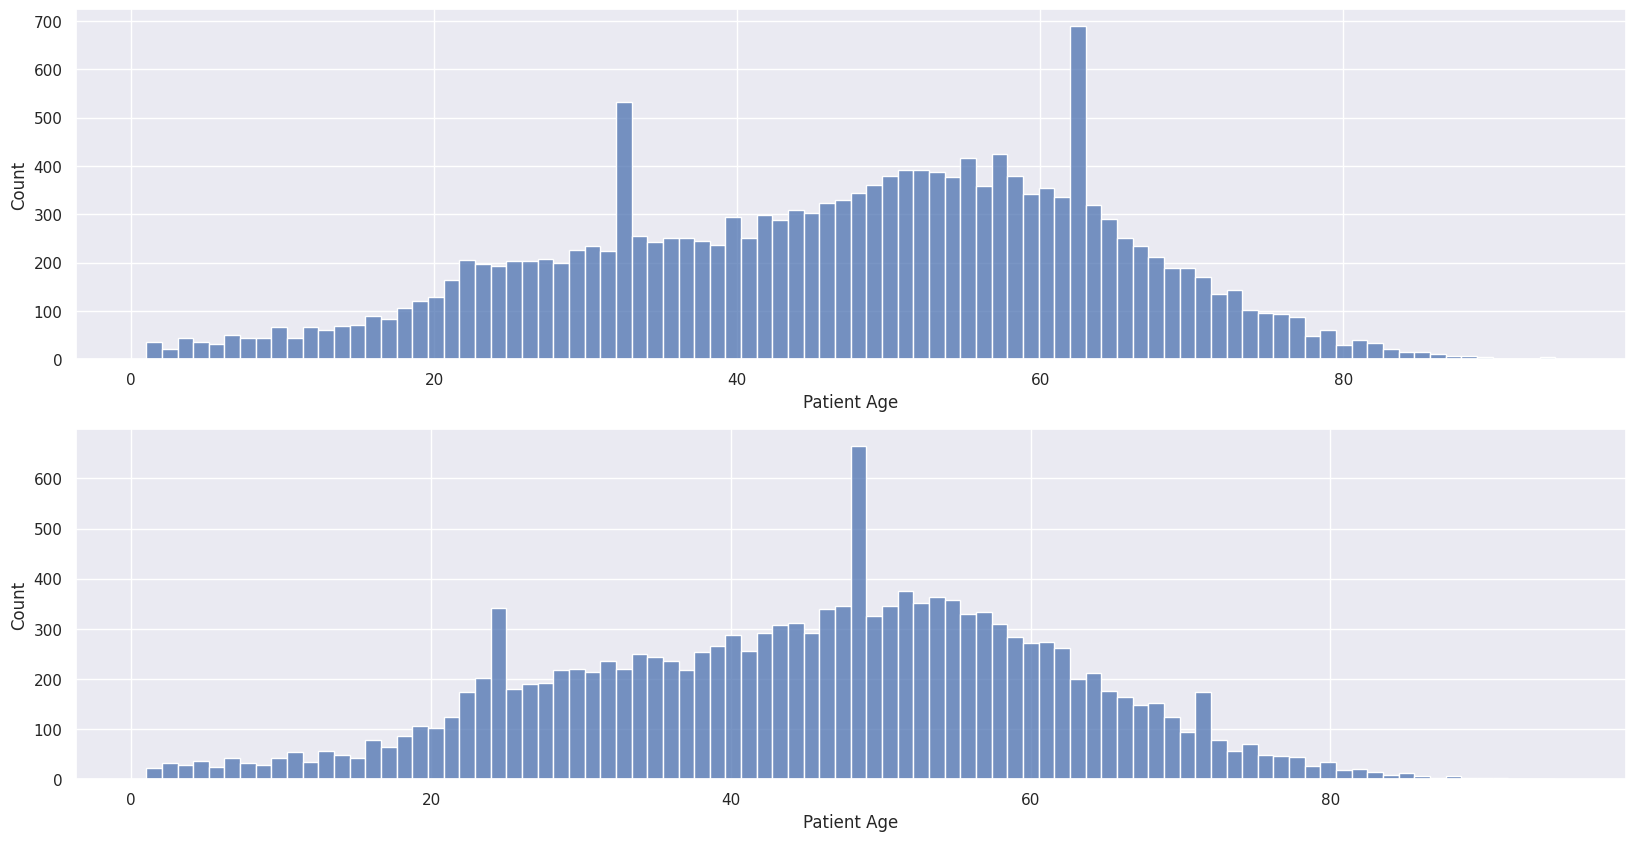

In [14]:
def age_by_gender_p1(df):
    test = df.groupby("Patient ID").agg('first')
    fig, axes = plt.subplots(2,1,figsize=(20,10))

    for i, val in enumerate(["M","F"]):
        test1 = test[test['Patient Gender'] == val].reset_index()
        sns.histplot(test1, x="Patient Age", ax=axes[i], bins=90)

    plt.show(sns)
    
age_by_gender_p1(df)

## 3.2 Distribution of Finding Labels by Gender?


The Cardiomegaly label is the only label in which more images are of female patients.

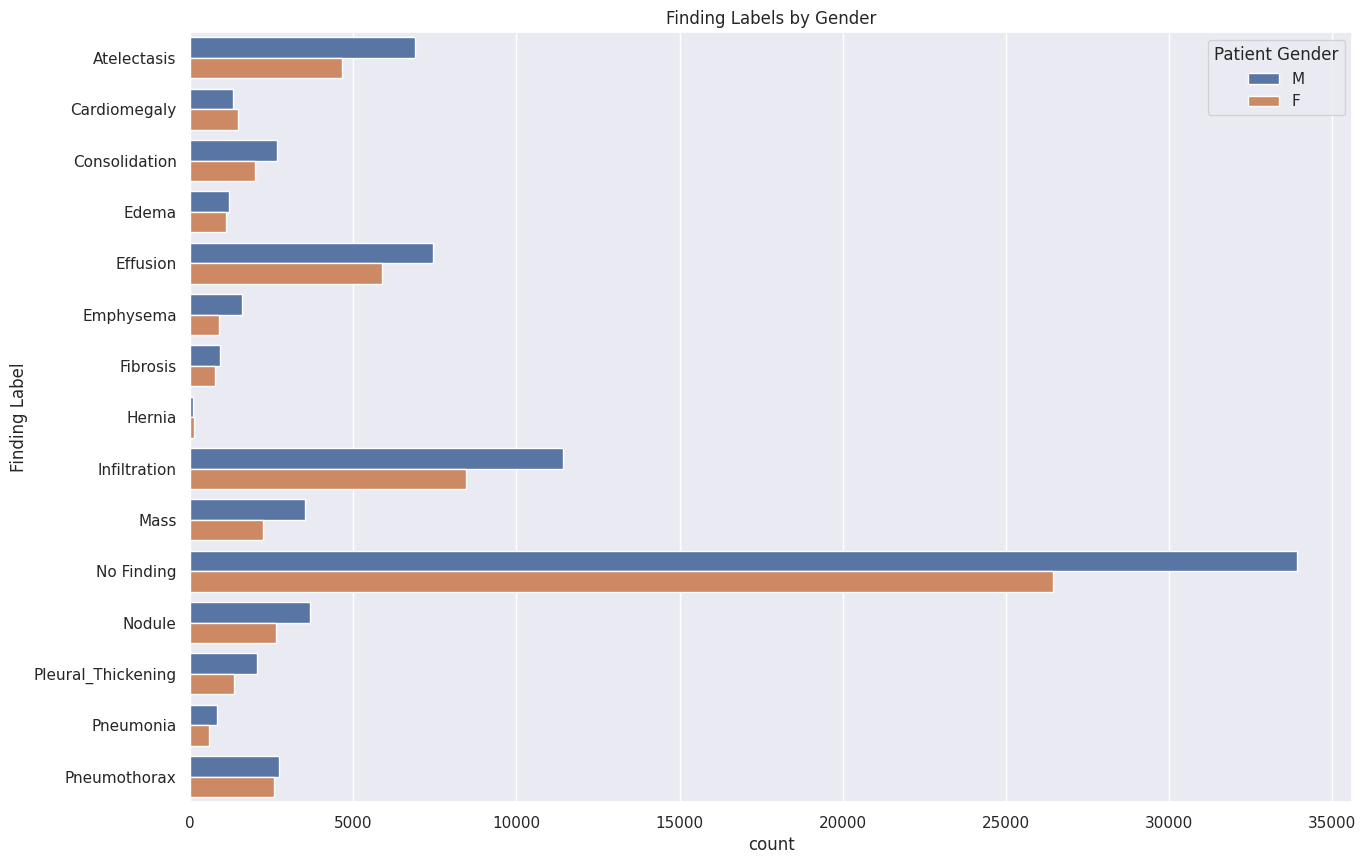

In [15]:
def labels_by_gender_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
    plot_df = pd.DataFrame()

    for val in ["M", "F"]:
        test1 = test[test["Patient Gender"] == val].reset_index(drop=True)
        test1 = test1.groupby("var1").size().sort_index().reset_index(name="count")
        test1["Patient Gender"] = val

        plot_df = pd.concat([plot_df, test1]).reset_index(drop=True)

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Gender")
    ax = sns.barplot(y="var1", hue="Patient Gender", x="count", data=plot_df, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)

labels_by_gender_p1(df)

## 3.3 Distribution of Finding Labels by Age?

There is some significant difference between the relative percentage of finding labels across the age groups. In the following cell, the percentage of finding labels within each group is plotted.

- The plot suggests that Patients under 29 years old are more likely to have `Pneumothorax`, `Infiltration` or `No Finding` than the rest of the population.

- Patients older than 69 years old are more likely to have `Pleural_Thickening`, `Fibrosis`, `Hernia`, `Emphysema`, `Effusion`, `Cardiomegaly`, and `Atelectasis` than other age groups. This high relative percentage could be because older patients are the least likely to have no findings on their X-rays.

- Patients in the 30 - 49 age group are consistently in the middle of the pack, yet fall a close second in the `Edema` and `Cardiomegaly` categories.

- Finally, patients in the 50 - 69 age group are more likely than other age groups to have the finding labels `Nodule` and `Mass`.

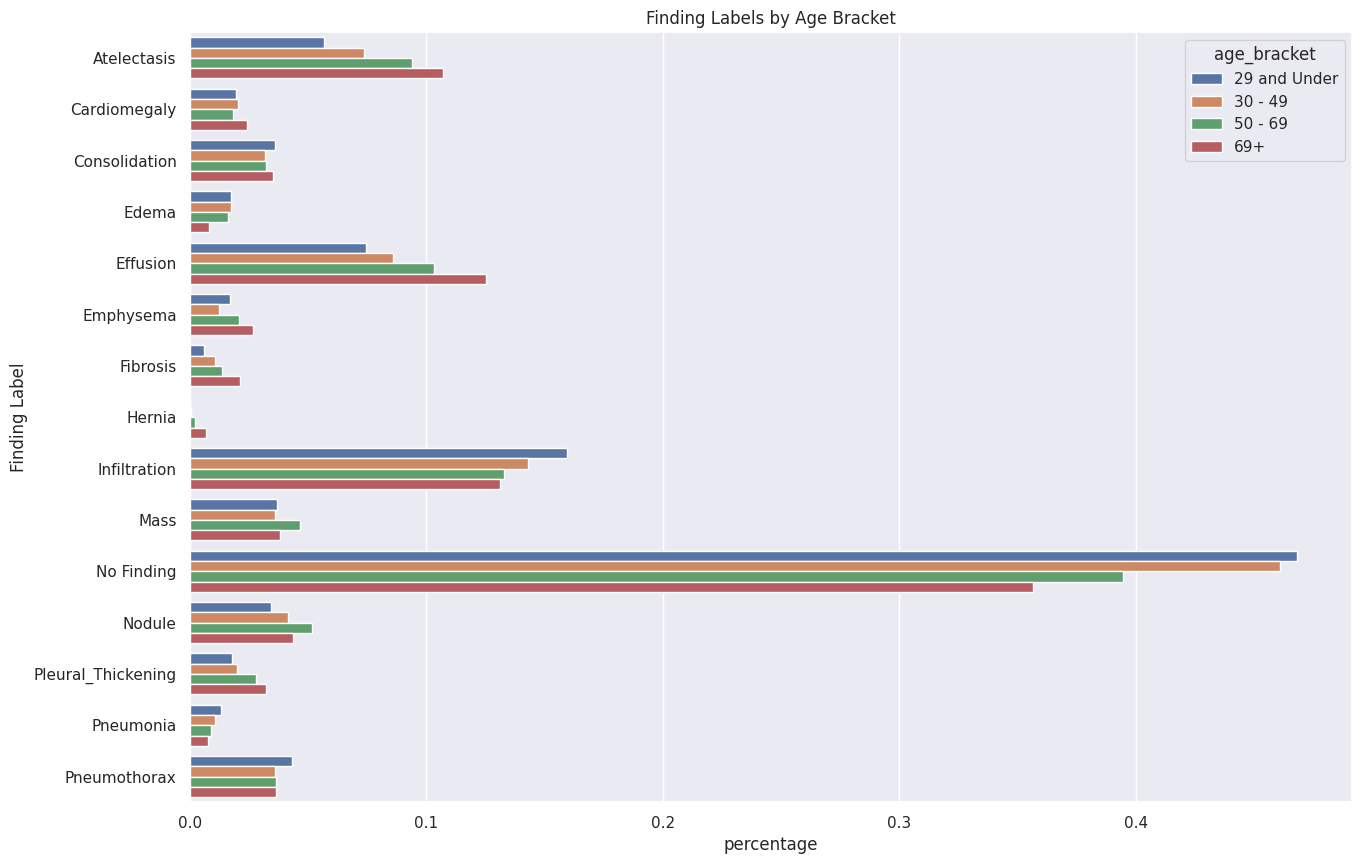

In [16]:
def labels_by_age_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

    conditions = [
        (test['Patient Age'] <= 29),
        (test['Patient Age'] >= 30) & (test['Patient Age'] <= 49),
        (test['Patient Age'] >= 50) & (test['Patient Age'] <= 69),
        (test['Patient Age'] >= 60)
    ]

    choices = ['29 and Under', '30 - 49', '50 - 69', '69+']
    test['age_bracket'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("age_bracket").sum("count").reset_index()

    test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
    test1["percentage"] = test1["count"]/test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Age Bracket")
    ax = sns.barplot(y="var1", hue="age_bracket", x="percentage", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
labels_by_age_p1(df)

## 3.4 Distribution of Finding Labels by Follow-up Number?

In the following plot. The more visits a patient makes (ie. the greater the follow-up #), the more likely it is that the finding labels are not labeled with `No Finding`.

- Some of the finding labels that are diagnoses with a higher proportion in later visits are `Cardiomegaly`, `Consolidation`, `Edema`, `Effusion`, `Infiltration`, `Pleural_Thickening`, `Pneumonia`, and `Pneumothorax`. 

- Interestingly, the `Nodule` label is more likely to be classified in earlier visits. Maybe this label is easier to classify than others?

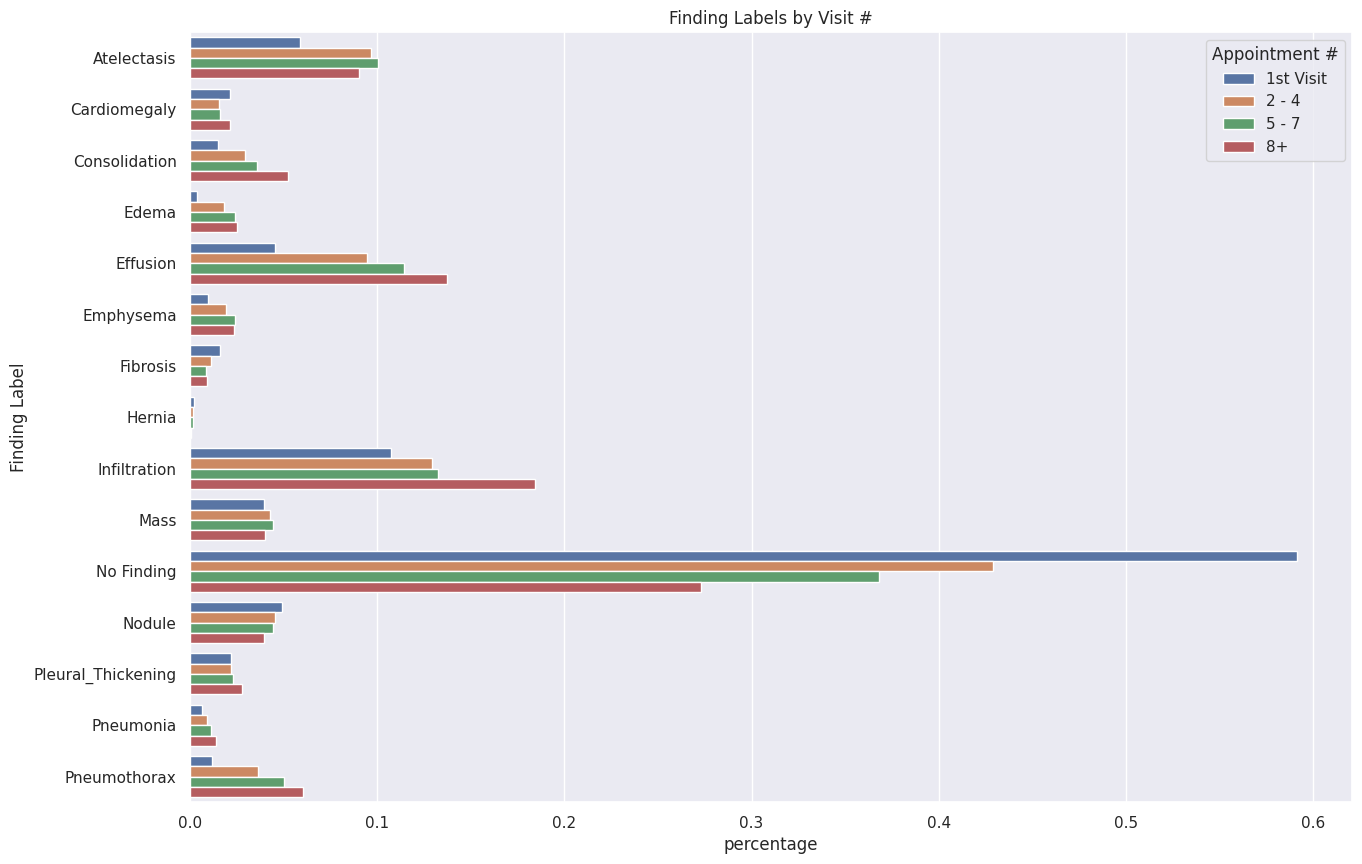

In [17]:
def labels_by_follow_up_p1(df):
    
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

    conditions = [
        (test['Follow-up #'] <= 1),
        (test['Follow-up #'] >= 2) & (test['Follow-up #'] <= 4),
        (test['Follow-up #'] >= 5) & (test['Follow-up #'] <= 7),
        (test['Follow-up #'] >= 8)
    ]

    choices = ['1st Visit', '2 - 4', '5 - 7', '8+']
    test['Appointment #'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(["Appointment #", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("Appointment #").sum("count").reset_index()

    test1 = test1.merge(test2, on='Appointment #', suffixes=('', '_total'))
    test1["percentage"] = test1["count"]/test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Visit #")
    ax = sns.barplot(y="var1", hue="Appointment #", x="percentage", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
labels_by_follow_up_p1(df)

## 3.5 Labels With More Than One Disease?

In the following cell, single vs multi-label diagnoses are evaluated. Since "No Finding" is mutually exclusive this label option is removed.

- Interestingly, once "No Finding" is removed, every label is found more often as in a multi-label classification. This is more pronounced with the `Atelectasis` and `Effusion` labels. That being said, the `Infiltration` and `Hernia` labels are close to a 50/50 split.

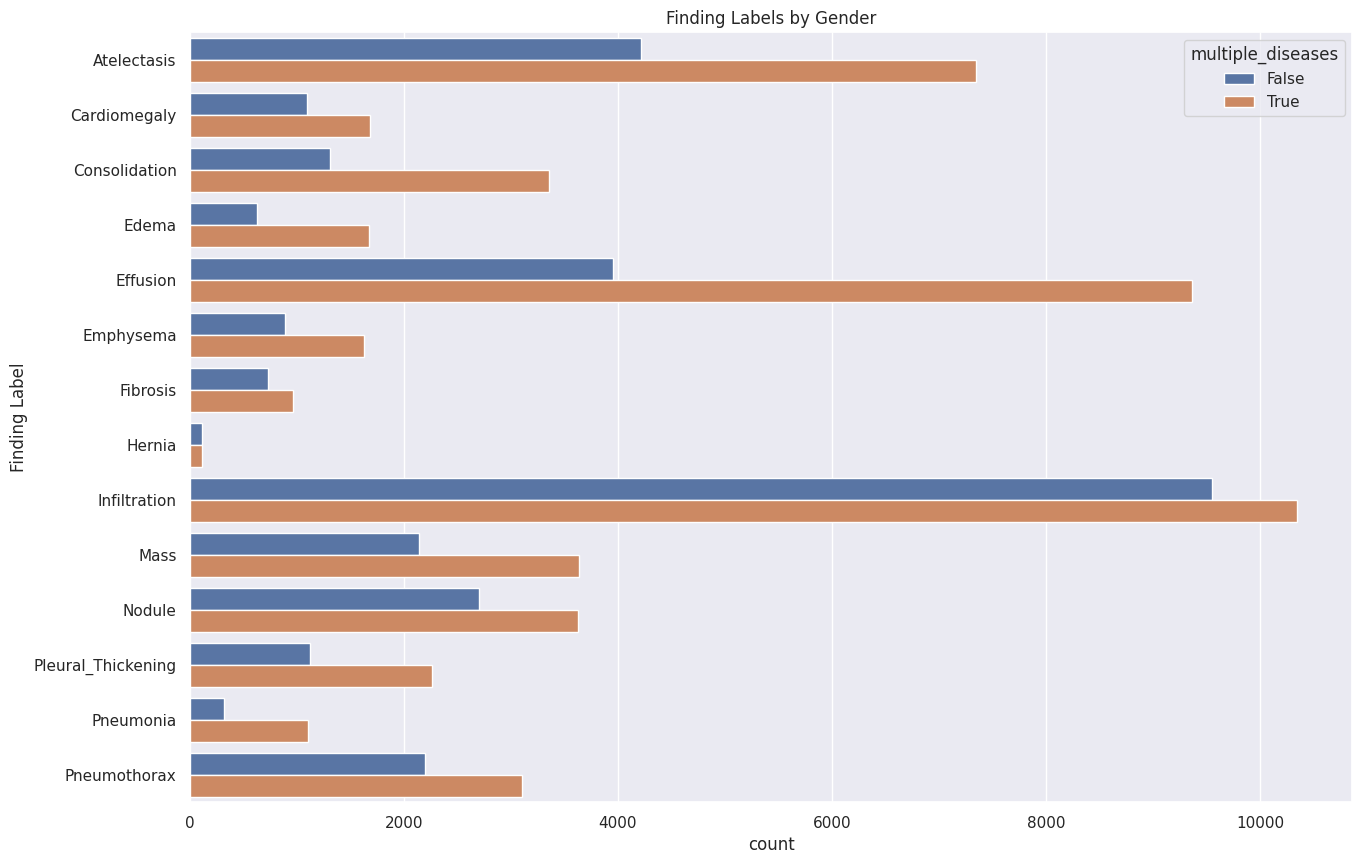

In [18]:
def single_multiple_diseases_p1(df):
    test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
    test["multiple_diseases"] = test['Finding Labels'].str.match(r'\w+\|\w+') #counting "|" occurances
    test = test[test["Finding Labels"]!="No Finding"]
    test1 = test.groupby(["var1", "multiple_diseases"]).size().sort_index().reset_index(name="count")

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Gender")
    ax = sns.barplot(y="var1", hue="multiple_diseases", x="count", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
single_multiple_diseases_p1(df)

## 3.6 Labels Found Together?

Some labels are going to be found more often together than others. The following section is looking solely at the possible combinations of **two labels**.

- As shown in the plot below, all possible label combinations are found in the dataset. This is an interesting finding in itself but does not reveal anything about the relative frequency of each relationship.

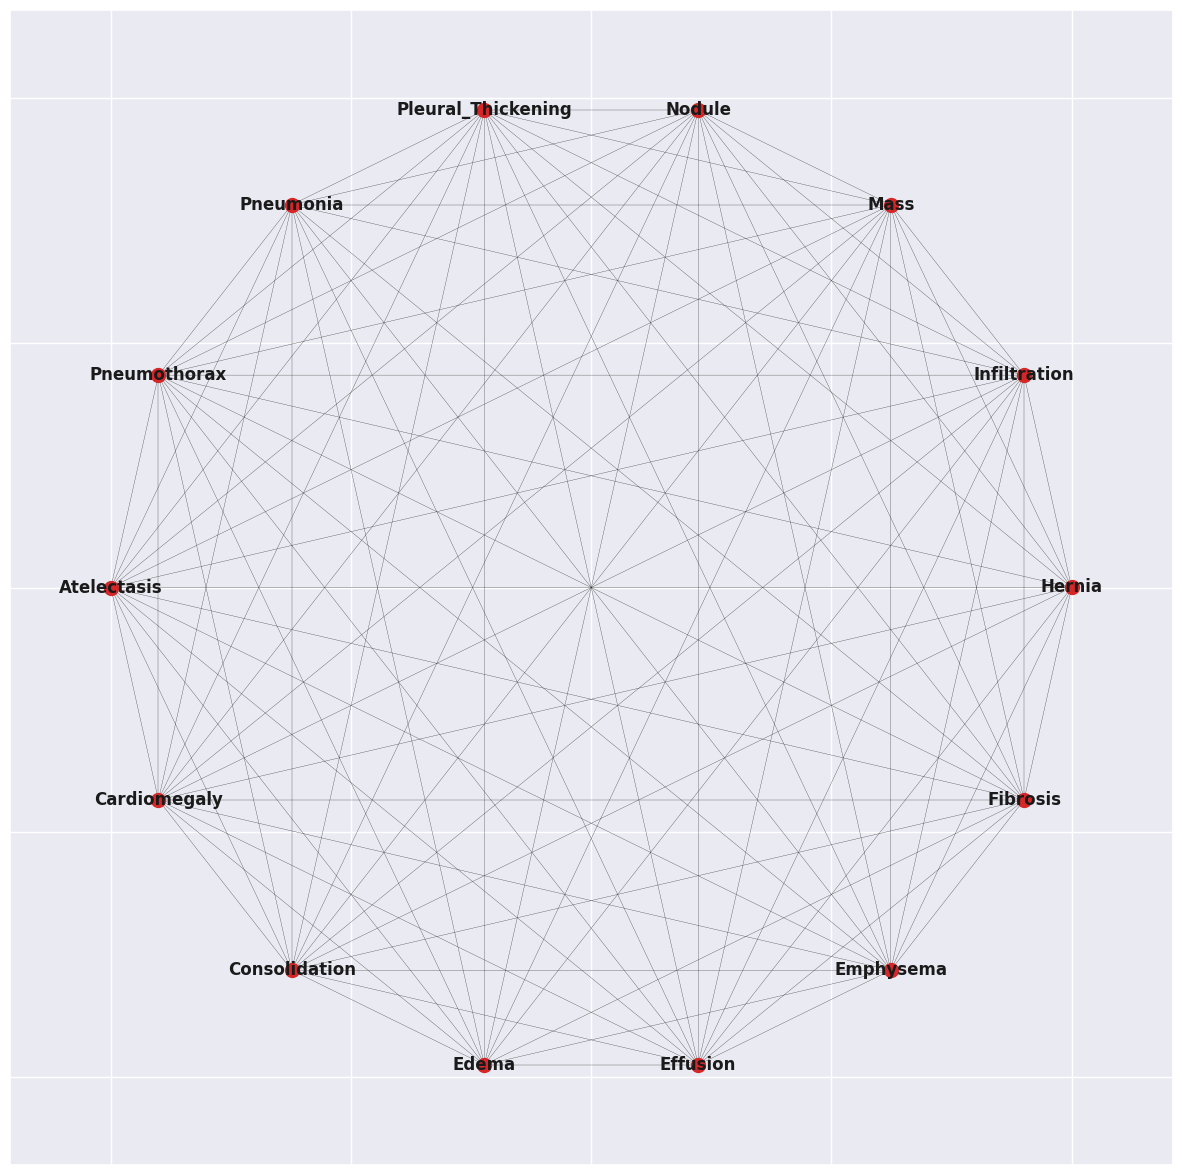

In [19]:
def label_groups_p1(df):
    #preprocessing data
    df = df[df["Finding Labels"].str.count(r'\|') == 1]
    df["tags"] = df["Finding Labels"].str.split("|")
    df["tags"] = df["tags"].apply(lambda x: sorted(x))

    #getting unique labels
    all_tags = np.unique(np.concatenate(df['tags'].values))
    all_tags

    #add edge helper
    def add_edge_weight(head, tail):
        try:
            weight = G[head][tail]['weight']
        except:
            G.add_edge(head, tail, weight=1)
        else:
            G[head][tail]['weight'] += 1

    # initialize graph
    G = nx.Graph()

    # add all nodes (tags)
    for t in all_tags:
        G.add_node(t)

    # add all edges (tags occurring together)
    for q in df.index:
        tags = df.loc[q, 'tags']
        for i in range(len(tags)-1):
            for j in range(i+1, len(tags)):
                add_edge_weight(tags[i], tags[j])

    plt.figure(figsize=(15,15))
    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='tab:red')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=0.2)
    nx.draw_networkx_labels(G, pos, {n: str(n) for n in list(G.nodes())}, font_weight='bold', font_color='k')
    plt.show()
    
label_groups_p1(df)

To explore the relative frequency of each relationship, another Networkx graph is created with the width of the edges in proportion to the number of occurrences in the data.

- This graph reveals that the most frequent pairings are between `Infiltration` - `Atelectasis`, `Infiltration` - `Effusion` and `Atelectasis` - `Effusion`.

- In the previous sub-section it was shown that these three labels were likely to be found with other labels. This could explain their relatively high frequency in this plot.

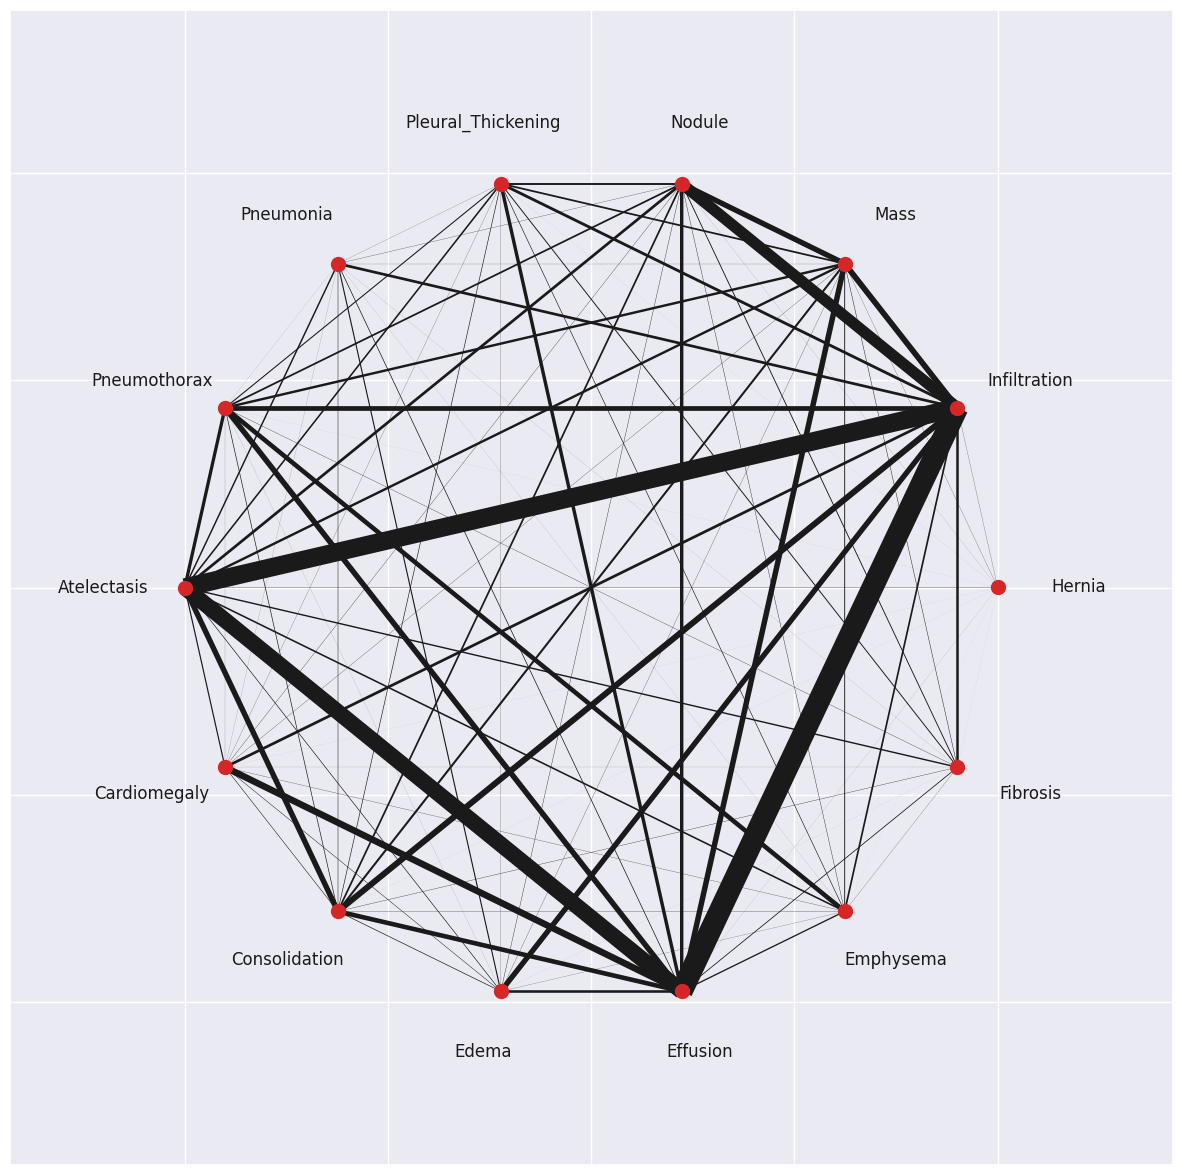

In [20]:
def label_groups_p2(df):
    #preprocessing data
    df = df[df["Finding Labels"].str.count(r'\|') == 1]
    df["tags"] = df["Finding Labels"].str.split("|")
    df["tags"] = df["tags"].apply(lambda x: sorted(x))

    #getting unique labels
    all_tags = np.unique(np.concatenate(df['tags'].values))
    all_tags

    #add edge helper
    def add_edge_weight(head, tail):
        try:
            weight = G[head][tail]['weight']
        except:
            G.add_edge(head, tail, weight=1)
        else:
            G[head][tail]['weight'] += 1

    # initialize graph
    G = nx.Graph()

    # add all nodes (tags)
    for t in all_tags:
        G.add_node(t)

    # add all edges (tags occurring together)
    for q in df.index:
        tags = df.loc[q, 'tags']
        for i in range(len(tags)-1):
            for j in range(i+1, len(tags)):
                add_edge_weight(tags[i], tags[j])

    plt.figure(figsize=(15,15))
    pos = nx.shell_layout(G)

    #calc total weights
    w_sum = 0
    for (node1,node2,data) in G.edges(data=True):
        w_sum += data['weight']

    #draw edges + nodes
    for (node1,node2,data) in G.edges(data=True):
        width = data["weight"]*len(G.nodes)*10.0/w_sum
        nx.draw_networkx_edges(G,pos,edgelist=[(node1, node2)],width=width)

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='tab:red')

    #draw labels w/ out overlap
    new_pos = {k: np.asarray([v[0]*1.2, v[1]*1.15]) for k, v in pos.items()}
    nx.draw_networkx_labels(G, new_pos, {n: str(n) for n in list(G.nodes())})
    plt.margins(x=0.15, y=0.15)
    plt.show()
    
label_groups_p2(df)

# 4. Preprocessing

## 4.1 One Hot Encoding

In [21]:
labels = df["Finding Labels"].unique()
n_labels = [x.split('|') for x in list(df["Finding Labels"])]

multilabel_binarizer = MultiLabelBinarizer()
y = multilabel_binarizer.fit_transform(n_labels)

extract_labels = list(multilabel_binarizer.classes_)
extract_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [22]:
n_df = pd.DataFrame(y)
n_df = n_df.set_axis(extract_labels, axis = 1)
# n_df.drop("No Finding",axis=1 ,inplace= True)
n_df.insert(0,"Path", value=df["Image Index"])
n_df.head()

,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [23]:
n_df.to_csv("labels.csv", index = False)

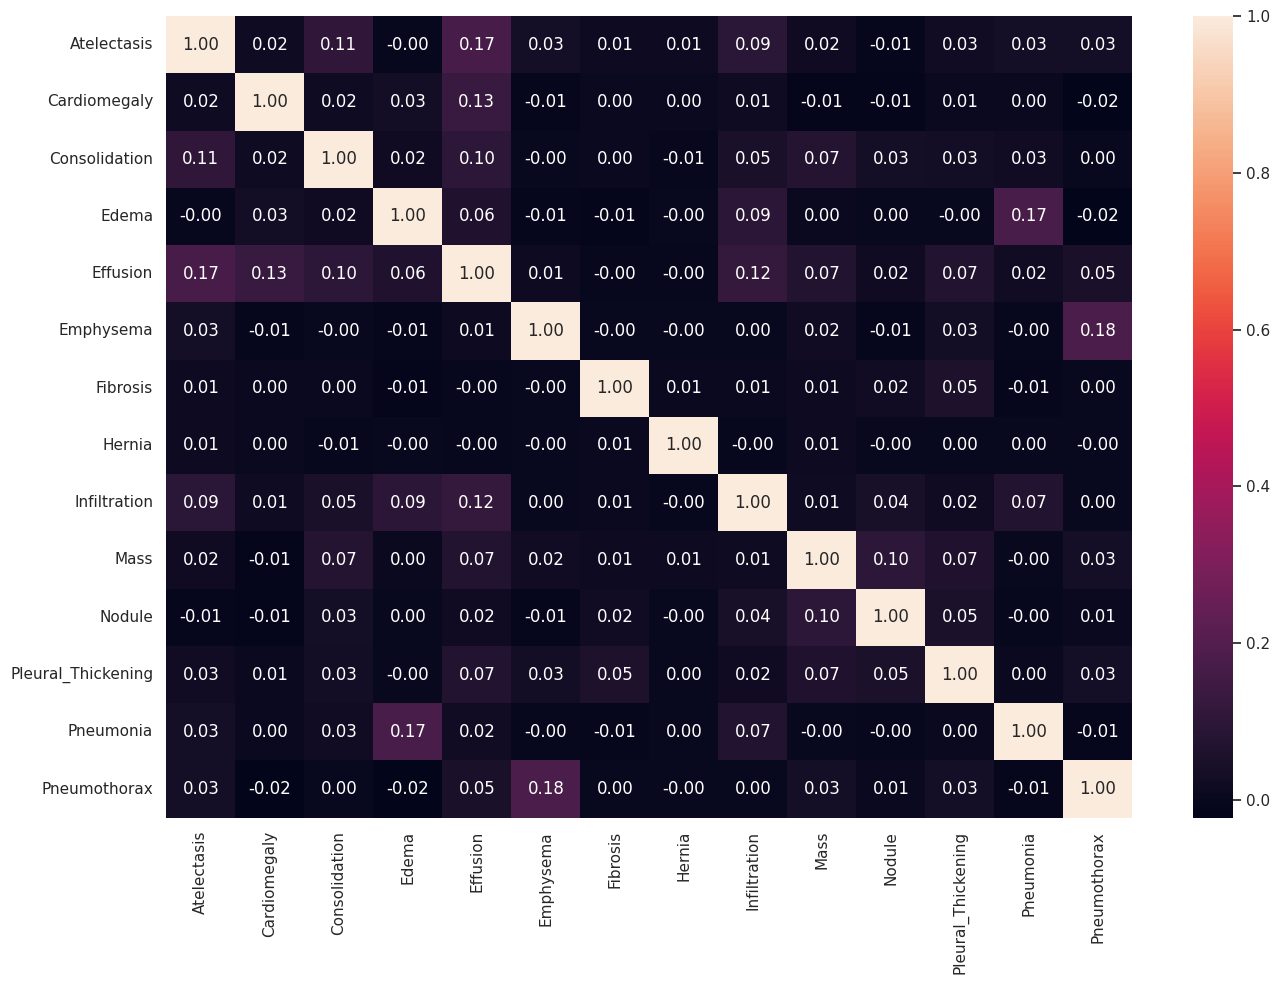

In [24]:
df_WO_NoFindings = n_df.drop(columns =["No Finding"])

plt.figure(figsize=(14, 10))
heatmap = sns.heatmap(df_WO_NoFindings.iloc[:, 1:].corr(), annot=True, fmt=".2f")
plt.tight_layout()
plt.show()

In [31]:
import pandas as pd
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split

# Load the label table
labels_df = pd.read_csv('/home/ozien/Untitled Folder/XAI/Data/new_labels.csv')

# Define image directory - corrected path (remove duplicate 'resized_images')
image_dir = '/home/ozien/Untitled Folder/XAI/Data/resized_images/'  # Single directory
grid_size = 16  # 16x16 grid for 256x256 images

# Verify the directory exists
if not os.path.exists(image_dir):
    raise FileNotFoundError(f"Image directory not found: {image_dir}")

# Take a 10% sample of the data
sample_size = 0.1
labels_sample, _ = train_test_split(
    labels_df, test_size=1 - sample_size, random_state=42)

# Function to extract grid features with error handling


def extract_grid_features(image_path):
    full_path = os.path.join(image_dir, image_path)

    if not os.path.exists(full_path):
        print(f"Warning: Image not found at {full_path} - using zero features")
        return np.zeros(grid_size * grid_size)

    try:
        image = imread(full_path, as_gray=True)
        if image.shape != (256, 256):
            image = resize(image, (256, 256))

        cell_size = 256 // grid_size
        features = []
        for i in range(grid_size):
            for j in range(grid_size):
                cell = image[i*cell_size:(i+1)*cell_size,
                             j*cell_size:(j+1)*cell_size]
                features.append(np.mean(cell))
        return np.array(features)
    except Exception as e:
        print(f"Error processing {full_path}: {str(e)}")
        return np.zeros(grid_size * grid_size)


# Extract features for the sample with progress feedback
X_sample = []
for i, path in enumerate(labels_sample['Path']):
    if i % 100 == 0:
        print(f"Processing image {i}/{len(labels_sample)}")
    X_sample.append(extract_grid_features(path))
X_sample = np.array(X_sample)

# List of disease labels
disease_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
                   'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
                   'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Y_sample = labels_sample[disease_columns].values

# Select the top 10 features per disease from the sample
k = 10
selected_features = set()
for d in range(Y_sample.shape[1]):
    disease_label = Y_sample[:, d]
    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_sample, disease_label)
    selected_indices = selector.get_support(indices=True)
    selected_features.update(selected_indices)

# Function to extract only the selected features


def extract_selected_features(image_path, selected_indices):
    full_path = os.path.join(image_dir, image_path)

    if not os.path.exists(full_path):
        print(f"Warning: Image not found at {full_path} - using zero features")
        return np.zeros(len(selected_indices))

    try:
        image = imread(full_path, as_gray=True)
        if image.shape != (256, 256):
            image = resize(image, (256, 256))

        cell_size = 256 // grid_size
        features = []
        for idx in selected_indices:
            i, j = divmod(idx, grid_size)
            cell = image[i*cell_size:(i+1)*cell_size,
                         j*cell_size:(j+1)*cell_size]
            features.append(np.mean(cell))
        return np.array(features)
    except Exception as e:
        print(f"Error processing {full_path}: {str(e)}")
        return np.zeros(len(selected_indices))


# Extract selected features for all images with progress feedback
X_full_selected = []
for i, path in enumerate(labels_df['Path']):
    if i % 1000 == 0:
        print(f"Processing full dataset {i}/{len(labels_df)}")
    X_full_selected.append(extract_selected_features(
        path, list(selected_features)))
X_full_selected = np.array(X_full_selected)

print(
    f"Selected {len(selected_features)} features out of 256 for the full dataset.")

Processing image 0/5138
Processing image 100/5138
Processing image 200/5138
Processing image 300/5138
Processing image 400/5138
Processing image 500/5138
Processing image 600/5138
Processing image 700/5138
Processing image 800/5138
Processing image 900/5138
Processing image 1000/5138
Processing image 1100/5138
Processing image 1200/5138
Processing image 1300/5138
Processing image 1400/5138
Processing image 1500/5138
Processing image 1600/5138
Processing image 1700/5138
Processing image 1800/5138
Processing image 1900/5138
Processing image 2000/5138
Processing image 2100/5138
Processing image 2200/5138
Processing image 2300/5138
Processing image 2400/5138
Processing image 2500/5138
Processing image 2600/5138
Processing image 2700/5138
Processing image 2800/5138
Processing image 2900/5138
Processing image 3000/5138
Processing image 3100/5138
Processing image 3200/5138
Processing image 3300/5138
Processing image 3400/5138
Processing image 3500/5138
Processing image 3600/5138
Processing im

In [ ]:
import pandas as pd
import numpy as np
import os
import logging
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Setup
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
image_dir = '/home/ozien/Untitled Folder/XAI/Data/resized_images/'
labels_csv = '/home/ozien/Untitled Folder/XAI/Data/new_labels.csv'
grid_size = 16  # 16x16 for 256x256
sample_size = 0.1
k = 20  # Top features to select globally

# Load labels
labels_df = pd.read_csv(labels_csv)
if not os.path.exists(image_dir):
    raise FileNotFoundError(f"Image directory not found: {image_dir}")

# Sample 10%
labels_sample, _ = train_test_split(
    labels_df, test_size=1 - sample_size, random_state=42)

# Function to extract 16x16 grid features


def extract_grid_features(image_path):
    full_path = os.path.join(image_dir, image_path)
    if not os.path.exists(full_path):
        logging.warning(f"Image not found at {full_path}")
        return np.zeros(grid_size * grid_size)
    try:
        image = imread(full_path, as_gray=True)
        if image.shape != (256, 256):
            image = resize(image, (256, 256), anti_aliasing=True)
        cell_size = 256 // grid_size
        return np.array([
            np.mean(image[i*cell_size:(i+1)*cell_size,
                    j*cell_size:(j+1)*cell_size])
            for i in range(grid_size) for j in range(grid_size)
        ])
    except Exception as e:
        logging.error(f"Error processing {full_path}: {str(e)}")
        return np.zeros(grid_size * grid_size)


# Extract features from sample
X_sample = np.array([extract_grid_features(p) for p in tqdm(
    labels_sample['Path'], desc="Extracting sample features")])

# Disease labels
disease_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
                   'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
                   'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Y_sample = labels_sample[disease_columns].values

# Aggregate MI scores across all diseases
mi_scores = np.zeros(X_sample.shape[1])
for d in range(Y_sample.shape[1]):
    y_disease = Y_sample[:, d]
    mi = mutual_info_classif(X_sample, y_disease, discrete_features=False)
    mi_scores += np.nan_to_num(mi)

# Select top k indices
top_k_indices = np.argsort(mi_scores)[-k:]
logging.info(f"Selected top {k} features globally across all diseases.")

# Save selected indices
np.save('selected_feature_indices.npy', top_k_indices)

# Function to extract only selected features


def extract_selected_features(image_path, selected_indices):
    full_path = os.path.join(image_dir, image_path)
    if not os.path.exists(full_path):
        logging.warning(f"Image not found at {full_path}")
        return np.zeros(len(selected_indices))
    try:
        image = imread(full_path, as_gray=True)
        if image.shape != (256, 256):
            image = resize(image, (256, 256), anti_aliasing=True)
        cell_size = 256 // grid_size
        return np.array([
            np.mean(image[i*cell_size:(i+1)*cell_size,
                    j*cell_size:(j+1)*cell_size])
            for idx in selected_indices
            for i, j in [divmod(idx, grid_size)]
        ])
    except Exception as e:
        logging.error(f"Error processing {full_path}: {str(e)}")
        return np.zeros(len(selected_indices))


# Extract selected features for the full dataset
X_full_selected = np.array([
    extract_selected_features(p, top_k_indices)
    for p in tqdm(labels_df['Path'], desc="Extracting selected features from full dataset")
])

# Optional normalization
scaler = StandardScaler()
X_full_selected_scaled = scaler.fit_transform(X_full_selected)
np.save('X_full_selected_scaled.npy', X_full_selected_scaled)
labels_df.to_csv('labels_cleaned.csv', index=False)

logging.info(f"Final feature shape: {X_full_selected_scaled.shape}")
logging.info("Feature extraction and selection complete.")

Extracting sample features:   0%|          | 0/5138 [00:00<?, ?it/s]

Extracting sample features: 100%|██████████| 5138/5138 [00:22<00:00, 226.41it/s]
INFO: Selected top 20 features globally across all diseases.
Extracting selected features from full dataset: 100%|██████████| 51382/51382 [03:13<00:00, 265.45it/s]
INFO: Final feature shape: (51382, 20)
INFO: Feature extraction and selection complete.


In [ ]:
# read npy file
import numpy as np
import pandas as pd
import os

# Load the data
X = np.load('X_full_selected_scaled.npy')
y = pd.read_csv('labels_cleaned.csv')


Shape of X: (51382, 20)
Shape of y: (51382, 16)


In [35]:
selected_features

{1,
 2,
 3,
 7,
 8,
 11,
 14,
 15,
 19,
 22,
 25,
 28,
 29,
 30,
 36,
 39,
 44,
 49,
 51,
 60,
 61,
 66,
 68,
 73,
 74,
 75,
 78,
 82,
 90,
 91,
 94,
 95,
 100,
 101,
 102,
 104,
 106,
 112,
 114,
 115,
 119,
 120,
 132,
 136,
 140,
 142,
 144,
 145,
 152,
 155,
 159,
 160,
 166,
 167,
 168,
 170,
 171,
 178,
 183,
 184,
 185,
 186,
 189,
 195,
 196,
 198,
 199,
 200,
 203,
 204,
 207,
 209,
 210,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 226,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 236,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252}

In [36]:
# Function to convert index to (row, column)
def index_to_grid(index, grid_size=16):
    row = index // grid_size
    column = index % grid_size
    return row, column

# Map selected indices to (row, column)
selected_grid_positions = {index: index_to_grid(index) for index in selected_features}

# Print a few examples
for idx, (row, col) in list(selected_grid_positions.items())[:5]:
    print(f"Index {idx}: Row {row}, Column {col}")

Index 1: Row 0, Column 1
Index 2: Row 0, Column 2
Index 3: Row 0, Column 3
Index 7: Row 0, Column 7
Index 8: Row 0, Column 8


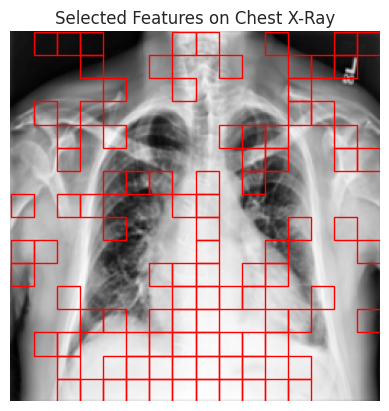

In [40]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

# Load a sample image (replace 'sample_image.png' with your image path)
sample_image = imread(
    '/home/ozien/Untitled Folder/XAI/Data/resized_images/00000001_002.png', as_gray=True)
if sample_image.shape != (256, 256):
    sample_image = resize(sample_image, (256, 256))  # Resize to match grid assumption

# Plot the image
plt.imshow(sample_image, cmap='gray')
plt.axis('off')

# Overlay selected grid cells
cell_size = 256 // 16  # Each cell is 16x16 pixels if image is 256x256
for index in selected_features:
    row, col = index_to_grid(index)
    plt.gca().add_patch(plt.Rectangle((col * cell_size, row * cell_size), cell_size, cell_size, 
                                      edgecolor='red', facecolor='none', linewidth=1))

plt.title("Selected Features on Chest X-Ray")
plt.show()

In [60]:
from tensorflow.python.client import device_lib
import tensorflow as tf

# Enable Eager Execution (required for TF v1-based builds like tensorflow-directml)
tf.compat.v1.enable_eager_execution()

# Check available devices
devices = device_lib.list_local_devices()

print("Available devices:")
for device in devices:
    print(f" - {device.name} ({device.device_type})")

Available devices:
 - /device:CPU:0 (CPU)
 - /device:DML:0 (DML)
 - /device:DML:1 (DML)


In [59]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Check if DirectML is available
try:
    from tensorflow_directml import DMLDevice
    dml_device = DMLDevice()
    print("DirectML is available.")
except ImportError:
    print("DirectML is not available. Ensure you have the tensorflow-directml package installed.")
    dml_device = None
    

TensorFlow version: 1.15.8
DirectML is not available. Ensure you have the tensorflow-directml package installed.


In [70]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

# Load the labels from a CSV file
labels_df = pd.read_csv(
    '/home/ozien/Untitled Folder/XAI/Data/new_labels.csv')

# Sample 5,100 images (10% of 51,000) while preserving balance
# Assuming the dataset is balanced, use random sampling
sampled_df = labels_df.sample(n=5100, random_state=42)

# Define the list of disease labels
disease_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
                   'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 
                   'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Split data into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(sampled_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Define image directory and size
image_dir = '/home/ozien/Untitled Folder/XAI/Data/resized_images/'
img_size = 256  # Images are 256x256 grayscale
tf.compat.v1.disable_eager_execution()
# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42
)


val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=32
)



# Define a custom layer to select specific features
def select_features(x, indices, original_size=256):
    # Assuming x is the flattened output of a conv layer with 256 features
    indices_tensor = K.constant([i-1 for i in indices], dtype='int32')  # Adjust for 0-based indexing
    selected = K.gather(x, indices_tensor)
    return selected

# Define the CNN model with feature selection
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    # Simulate 256 features (adjust based on actual conv output size)
    Dense(256, activation='relu'),  # Intermediate dense layer for feature extraction
    # Lambda(lambda x: select_features(x, selected_features, original_size=256)),  # Select 102 features
    Dense(512, activation='relu'),
    Dense(len(disease_columns), activation='sigmoid')  # Output for 15 diseases
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit_generator(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

Found 4080 validated image filenames.
Found 510 validated image filenames.
Found 510 validated image filenames.
Epoch 1/10


: 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import gray2rgb
from lime import lime_image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image

# Load your dataset metadata
labels_df = pd.read_csv('/kaggle/input/nih-balanced-and-resized-chest-x-rays/new_labels.csv')
disease_columns = ['Atelectasis', 'Cardiomegaly', ...]  # Your 15 conditions

# Create VGG16-based model adapted for grayscale X-rays
def create_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Freeze initial layers
    for layer in base_model.layers[:15]:
        layer.trainable = False
    
    # Add custom head for multi-label classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(len(disease_columns), activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

# Convert grayscale to pseudo-RGB (VGG requires 3 channels)
def preprocess_xray(img):
    img = image.img_to_array(img)
    img = gray2rgb(img)  # Convert to 3 channels
    img = preprocess_input(img)  # VGG-specific preprocessing
    return img

# LIME explanation function
def explain_xray(model, img_path, disease_index=0):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
    img_array = preprocess_xray(img)
    
    # Create explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Prediction wrapper for LIME
    def batch_predict(images):
        # Convert back to VGG input format
        processed = np.array([preprocess_xray(image.img_to_array(img)) for img in images])
        return model.predict(processed)
    
    # Generate explanation
    explanation = explainer.explain_instance(
        img_array, 
        batch_predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )
    
    # Visualization
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(image.img_to_array(img), cmap='gray')
    plt.title('Original X-ray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(image.img_to_array(img), cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.4)
    plt.title(f'LIME Explanation for {disease_columns[disease_index]}')
    plt.axis('off')
    plt.show()
    
    # Show predictions
    preds = model.predict(np.expand_dims(img_array, axis=0))[0]
    print("\nPredicted Probabilities:")
    for i, disease in enumerate(disease_columns):
        print(f"{disease}: {preds[i]:.4f}")

# Example usage
if __name__ == "__main__":
    # Initialize model
    model = create_vgg_model()
    
    # Load sample image (replace with your path)
    sample_img = '/kaggle/input/nih-balanced-and-resized-chest-x-rays/resized_images/resized_images/00000001_000.png'
    
    # Explain prediction for first disease (Atelectasis)
    explain_xray(model, sample_img, disease_index=0)

ValueError: Only 2D color images are supported

## 4.2 CLAHE 
Contrast Limited AHE (CLAHE) is a variant of adaptive histogram equalization in which the contrast amplification is limited, so as to reduce this problem of noise amplification.